# Gradient-Effected Object Recognition Gauge for hive Entrances (GEORGE)
Neural-net-powered honeybee hive-mounted pollen, varroa, and wasp counter

## Imports

In [1]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import io
import glob
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
from tqdm import tqdm
import math

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

import pandas as pd
import sys

import skimage
from skimage import io, transform
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import GEORGE_Library as GEORGE
%matplotlib inline

print("Done")

Done


## Define global variables

In [2]:
category_index = {1: {'id': 1, 'name': 'none'}, 2: {'id': 2, 'name': 'cooling'}, 3: {'id': 3, 'name': 'pollen'}, 4: {'id': 4, 'name': 'varroa'}, 5: {'id': 5, 'name': 'wasps'}}
train_augmented_fp = "Dataset/TrainAugmented"
val_augmented_fp = "Dataset/ValAugmented"
IMAGE_WIDTH = 75
IMAGE_HEIGHT = 150
EX_SUB = False
VAL_SIZE = 0.1
FILL_IMG = False

print("Done")

Done


## Load Datasets

image format is a uint8 numpy array with shape (img_height, img_width, 3)
label format is an array of four values, either 0 or 1 (e.g [0, 1, 0, 0] for pollen), where the first value corresponding to "none" is omitted and corresponding to a category index:

category_index = {1: {'id': 1, 'name': 'none'}, 2: {'id': 2, 'name': 'cooling'}, 3: {'id': 3, 'name': 'pollen'}, 4: {'id': 4, 'name': 'varroa'}, 5: {'id': 5, 'name': 'wasps'}}

In [3]:
try:
    files = os.listdir(train_augmented_fp)
    for file in files:
        file_path = os.path.join(train_augmented_fp, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
    files = os.listdir(val_augmented_fp)
    for file in files:
        file_path = os.path.join(val_augmented_fp, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
except OSError:
    print("Error")
    
dataset_paths = {'PD': {'none': {'path': 'Dataset/PollenDataset/None', 'label': [0, 0, 0, 0]},
                        'pollen': {'path': 'Dataset/PollenDataset/Pollen', 'label': [0, 1, 0, 0]}},
                 'BA': {'none': {'path': 'Dataset/BeeAlarmed/None', 'label': [0, 0, 0, 0]},
                        'cooling': {'path': 'Dataset/BeeAlarmed/Cooling', 'label': [1, 0, 0, 0]},
                        'pollen': {'path': 'Dataset/BeeAlarmed/Pollen', 'label': [0, 1, 0, 0]},
                        'varroa': {'path': 'Dataset/BeeAlarmed/Varroa', 'label': [0, 0, 1, 0]},
                        'wasps': {'path': 'Dataset/BeeAlarmed/Wasps', 'label': [0, 0, 0, 1]}},
                 'YM': {'none': {'path': 'Dataset/YangModel/None', 'label': [0, 0, 0, 0]},
                        'cooling': {'path': 'Dataset/YangModel/Cooling', 'label': [1, 0, 0, 0]},
                        'pollen': {'path': 'Dataset/YangModel/Pollen', 'label': [0, 1, 0, 0]},
                        'varroa': {'path': 'Dataset/YangModel/Varroa', 'label': [0, 0, 1, 0]}}}#,
                 # 'USU': {'none': {'path': 'Dataset/USU/None', 'label': [0, 0, 0, 0]},
                 #         'cooling': {'path': 'Dataset/USU/Cooling', 'label': [1, 0, 0, 0]},
                 #         'pollen': {'path': 'Dataset/USU/Pollen', 'label': [0, 1, 0, 0]},
                 #         'varroa': {'path': 'Dataset/USU/Varroa', 'label': [0, 0, 1, 0]}}}
file_list = []
for dataset_path in dataset_paths:
    for dataset in dataset_paths[dataset_path]:
        [file_list.append(i) for i in glob.glob(dataset_paths[dataset_path][dataset]['path'] + '/*')]
p = np.random.permutation(len(file_list))
train_random_file_list = [file_list[i] for i in p[0:(round(len(file_list) * (1 - VAL_SIZE)))]]
val_random_file_list = [file_list[i] for i in p[(round(len(file_list) * (1 - VAL_SIZE))):len(file_list)]]

with tqdm(total=len(file_list), unit="images", desc=str("Augment and save dataset images")) as pbar:
    for dataset_path in dataset_paths:
        for dataset in dataset_paths[dataset_path]:
            for filename in glob.glob(dataset_paths[dataset_path][dataset]['path'] + '/*'):
                image = Image.open(filename).convert('RGB')
                new_image = image
                if max(image.size) < min(IMAGE_WIDTH, IMAGE_HEIGHT):
                    ind = (image.size).index(max(image.size))
                    size = np.zeros(2)
                    size[ind] = min(IMAGE_WIDTH, IMAGE_HEIGHT)
                    size[1 - ind] = (size[ind] / image.size[ind]) * image.size[1 - ind]
                    new_image = image.resize((round(size[0]), round(size[1])))
                elif min(image.size) > max(IMAGE_WIDTH, IMAGE_HEIGHT):
                    ind = (image.size).index(min(image.size))
                    size = np.zeros(2)
                    size[ind] = max(IMAGE_WIDTH, IMAGE_HEIGHT)
                    size[1 - ind] = (size[ind] / image.size[ind]) * image.size[1 - ind]
                    new_image = image.resize((round(size[0]), round(size[1])))
                if np.array(new_image).max() <= 1:
                    new_image = np.array(new_image) * 255
                new_image = GEORGE.automatic_brightness_and_contrast(np.array(new_image).astype('uint8'))
                new_image = GEORGE.zoom_image(new_image)
                if EX_SUB:
                    new_image = GEORGE.extract_sub(np.array(new_image).astype('uint8'))
                new_image, new_coords = GEORGE.process_image(np.array(new_image).astype('uint8'))
                cat = str(GEORGE.get_label(dataset_paths[dataset_path][dataset]['label'])[2][0])
                str_name = []
                for coord in new_coords:
                    str_name.append(str(coord).split('.')[1])
                new_filename = "%s%s_%s_%s_%s.png" % (cat, str_name[0], str_name[1], str_name[2], str_name[3])
                if FILL_IMG:
                    temp_img = Image.fromarray(new_image)
                    h, w, _ = np.shape(temp_img)
                    mask = np.array(temp_img).astype('uint8')
                    for x in range(w):
                        for y in range(h):
                            if sum(mask[x][y]) == 0:
                                mask[x][y] = [255, 255, 255]
                            else:
                                mask[x][y] = [0, 0, 0]
                    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
                    new_image = cv2.inpaint(np.array(temp_img).astype('uint8'), mask, 5, cv2.INPAINT_NS)
                if filename in val_random_file_list:
                    Image.fromarray(np.array(new_image).astype('uint8')).save(val_augmented_fp + "/" + new_filename,"PNG")
                else:
                    Image.fromarray(np.array(new_image).astype('uint8')).save(train_augmented_fp + "/" + new_filename,"PNG")
                pbar.update(1)

print("Training set: {}, Validation set: {}".format(len(train_random_file_list), len(val_random_file_list)))

Augment and save dataset images: 100%|███████████████████████████████████████| 11297/11297 [11:08<00:00, 16.91images/s]

Training set: 10167, Validation set: 1130


## Let's just visualize the images as a sanity check

<function matplotlib.pyplot.show(close=None, block=None)>

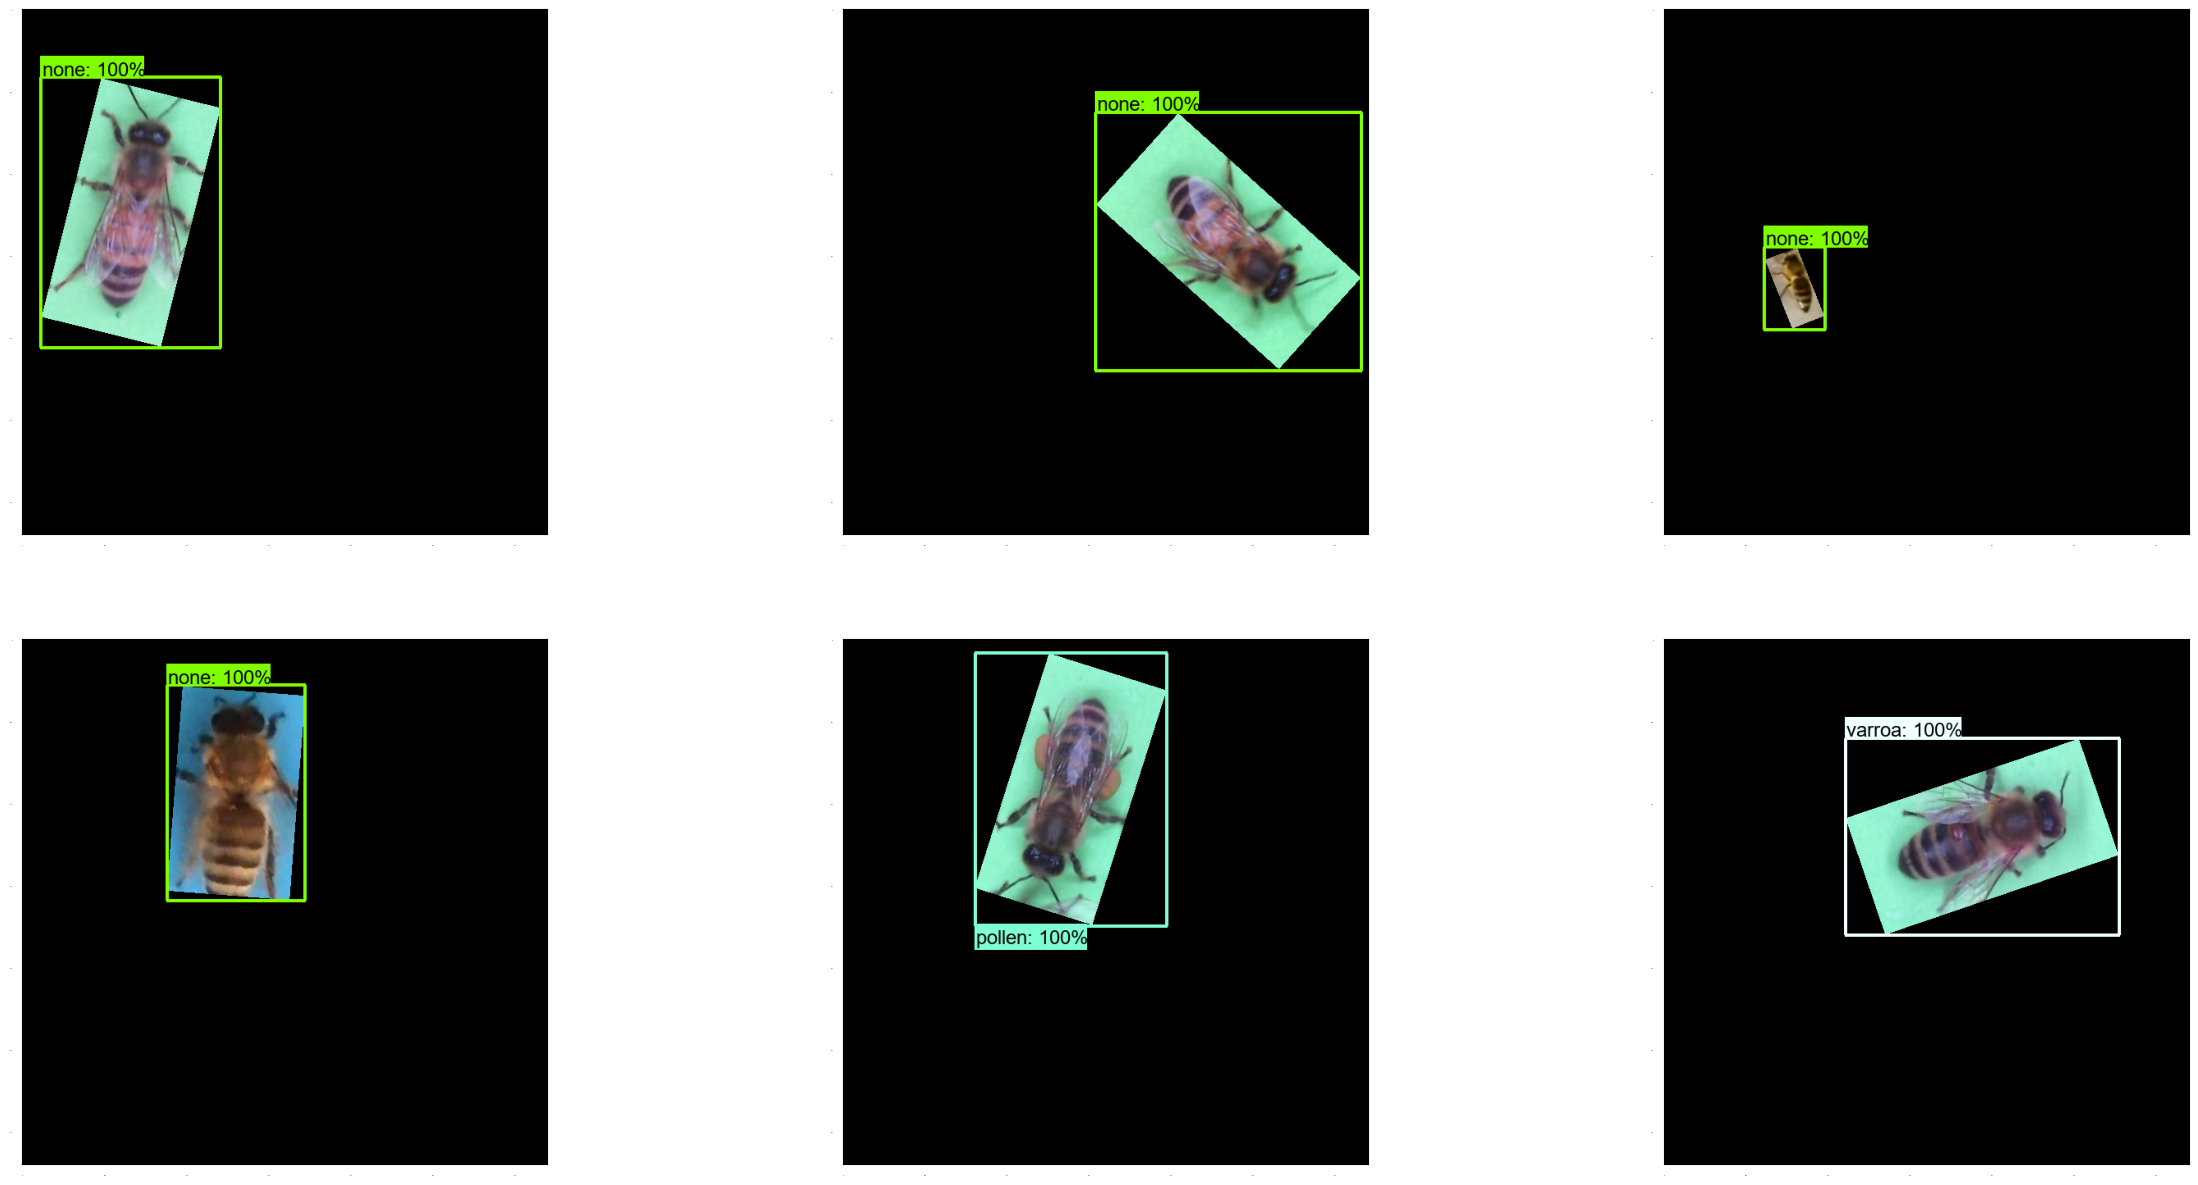

In [9]:
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [30, 15]

enum_file_subset = []
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

for i in range(6):
    rand_enum_val = random.randint(0, len(train_random_file_list))
    enum_file_subset.append(glob.glob(train_augmented_fp + '/*')[rand_enum_val])

for idx, filename in enumerate(enum_file_subset):
    plt.subplot(2, 3, idx+1)
    image, label, gt_box = GEORGE.get_file_and_info(filename)
    
    GEORGE.plot_detections(
        image,
        gt_box,
        np.array(label[2]),
        dummy_scores,
        category_index)
plt.show